# Выявление невыгодных источников трафика и перераспределение бюджета




## Изучение данных из файла

In [1]:
# установим необходимые библиотеки

import pandas as pd
import numpy as np
import math
from scipy import stats as st
import matplotlib.pyplot as plt 
import seaborn as sns

Положим данные о визитах, заказах и рекламных расходах в переменные
1.2. Подготовьте данные. Убедитесь, что тип данных во всех колонках соответствует сохранённым в них значениям.

### посмотрим таблицу visits_log с информацией о посещениях сайта

In [2]:
visits_log = pd.read_csv('/datasets/visits_log.csv')
visits_log.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
# в наименовании столбцов присутствуют пробелы, следует их переименовать

visits_log.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [4]:
# посмотрим на объем и типы данных в таблице

visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


пропусков в данных нет, однако столбцы с датами имеют строковый тип данных, это нужно исправить

In [5]:
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'])
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'])

In [6]:
# посмотрим самую раннюю дату и самую позднюю дату в таблице

print('Первая дата: ', visits_log['start_ts'].min())
print('Постедняя дата: ', visits_log['start_ts'].max())

Первая дата:  2017-06-01 00:01:00
Постедняя дата:  2018-05-31 23:59:00


в таблице собраны данные за год - с 1 июня 2017г. по 31 мая 2018 г.

In [7]:
# Проверим наличие дубликатов 

visits_log.duplicated().sum()

0

### посмотрим таблицу orders_log c информацией о заказах

In [8]:
orders_log = pd.read_csv('/datasets/orders_log.csv')
orders_log.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [9]:
# в наименовании столбцов присутствуют пробелы, следует их переименовать

orders_log.columns = ['buy_ts', 'revenue', 'uid']

In [10]:
# посмотрим на объем и типы данных в таблице

orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [11]:
# пропусков в данных нет, однако столбцы с датами имеют строковый тип данных, это нужно исправить

orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'])

In [12]:
# Проверим наличие дубликатов 

orders_log.duplicated().sum()

0

Посмотрим как распределились покупки по источникам трафика

In [13]:
visits_log.merge(orders_log, on='uid').groupby('source_id')['source_id'].count()

source_id
1     248662
2     238297
3      46766
4      62683
5     151824
7          1
9       9547
10      4027
Name: source_id, dtype: int64

в связи с тем, что в таблице есть одно выбивающееся значение - в частности, одна покупка с неизвестного источника 7, которая никак не влияет на дальнейшие расчеты, нужно его устранить.


In [14]:
visits_log=visits_log.query('source_id != "7"')

### посмотрим таблицу costs с информацией о расходах на маркетинг

In [15]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [16]:
# посмотрим на объем и типы данных в таблице

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [17]:
# пропусков в данных нет, однако столбец с датами имеет строковый тип данных, нужно исправить

costs['dt'] = pd.to_datetime(costs['dt'])

In [18]:
# Проверим наличие дубликатов 

costs.duplicated().sum()

0

ВЫВОДЫ

Посмотрели таблицы, убедились, что данные введены корректно, пропусков и дубликатов нет.
Данные приведены к правильному типу и поправлены названия столбцов. 

## Рассчитаем метрики и построим графики

Посчитаем метрики трёх видов:

    продуктовые,
    метрики электронной коммерции,
    маркетинговые.

Отобразим на графиках изменения каждой метрики во времени. Всякий раз старайтесь подобрать наиболее подходящий тип визуализации: в некоторых случаях может быть уместна тепловая карта когортного анализа.
После каждого пункта сформулируйте выводы.

### Продуктовые метрики

В этом блоке мы рассчитаем продуктовые метрики

    - DAU, WAU и MAU. Вычислим средние значения этих метрик за весь период. Отобразим изменения метрик во времени на графиках;
    - Определим, сколько раз за день пользователи в среднем заходят на сайт. Построим график, отражающий изменения метрики во времени;
    - Исследуем, сколько времени пользователи проводят на сайте. Узнаем продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, построим график распределения. 
    - Рассчитаем Retention Rate, применяя когортный анализ. Покажем изменения метрики во времени на графике. Найдем средний Retention Rate на второй месяц «жизни» когорт.

In [19]:
# для рассчета метрик добавим необходимые колонки

visits_log['session_year'] = visits_log['start_ts'].astype('datetime64[Y]')
visits_log['session_month'] = visits_log['start_ts'].astype('datetime64[M]')
visits_log['session_week'] = visits_log['start_ts'].astype('datetime64[W]')
visits_log['session_date'] = visits_log['start_ts'].astype('datetime64[D]')

#### Рассчитаем и изучим метрики DAU, WAU и MAU

Вычислим средние значения этих метрик за весь период.
DAU (Daily Active Users) — это количество уникальных пользователей за сутки.
WAU (Weekly Active Users) — это количество пользователей за неделю. 
MAU (Monthly Active Users) — это количество уникальных пользователей за месяц.

In [20]:
dau = visits_log.groupby('session_date').agg({'uid': 'nunique'})
dau_total = dau.mean()
wau = visits_log.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})
wau_total = wau.mean()
mau = visits_log.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})
mau_total = mau.mean()

print('Средние значения DAU, WAU и MAU за весь период')
print('Daily active users: ', int(dau_total))
print('Weekly active users: ', int(wau_total))
print('Monthly active users: ', int(mau_total))

Средние значения DAU, WAU и MAU за весь период
Daily active users:  907
Weekly active users:  5621
Monthly active users:  23225


Отобразим изменения метрик во времени на графиках

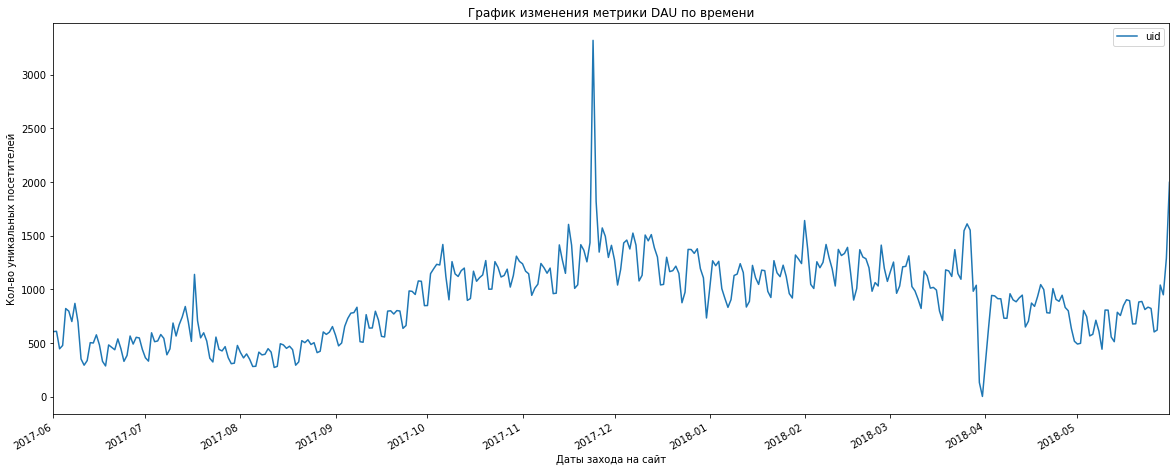

In [21]:
# Построим график DAU 

dau.reset_index().plot(y = 'uid', x = 'session_date', figsize = (20,8))
plt.title('График изменения метрики DAU по времени')
plt.xlabel('Даты захода на сайт')
plt.ylabel('Кол-во уникальных посетителей')

plt.show()


на графике замете большой выброс в конце ноября, посмотрим на дату

In [22]:
# посмотрим, что за выброс. 

visits_log.groupby('session_date').agg({'uid': 'nunique'}).sort_values(by='uid', ascending=False).head()


,uid
session_date,
2017-11-24,3319
2018-05-31,1996
2017-11-25,1817
2018-02-01,1640
2018-03-26,1609


24 ноября 2917 года - черная пятница.

В целом прослеживается закономерность, что посещение пользователями Яндекс.Афиши в выходные всегда выше, чем в будни.

Заметны 2 экстремальных значения:
     
     - всплеск заходов более чем в 2 раза выше обыкновенного приходится на 24 ноября 2017 года - черную пятницу
     - провал 30-31 марта 2018 г. (возможно в эти дни проводились технические работы)

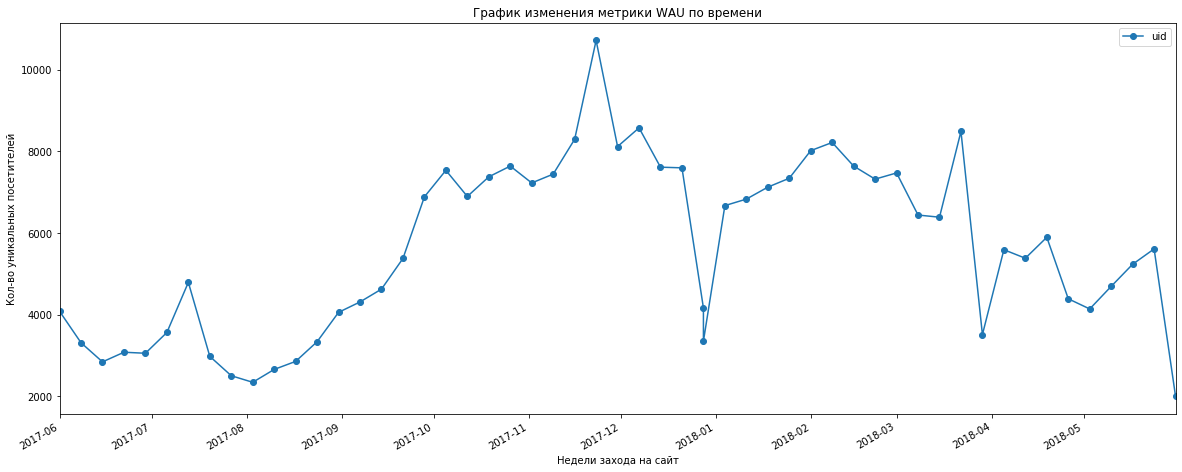

In [23]:
# Построим график WAU 

wau.reset_index().plot(y = 'uid', x = 'session_week', style = 'o-', figsize = (20,8))
plt.title('График изменения метрики WAU по времени')
plt.xlabel('Недели захода на сайт')
plt.ylabel('Кол-во уникальных посетителей')

plt.show()


По недельным данным можно отметить, что в летнее время и перед новым годом посещаемость ниже, чем в другие недели. Видимо люди находятся в отпусках или за городом, афиша мероприятий их интересует меньше, чем осенью и зимой.
Также виден всплеск заходов в конце ноября 2017г. и провал на последней недел марта 2018 30-31 марта 2018 г. 

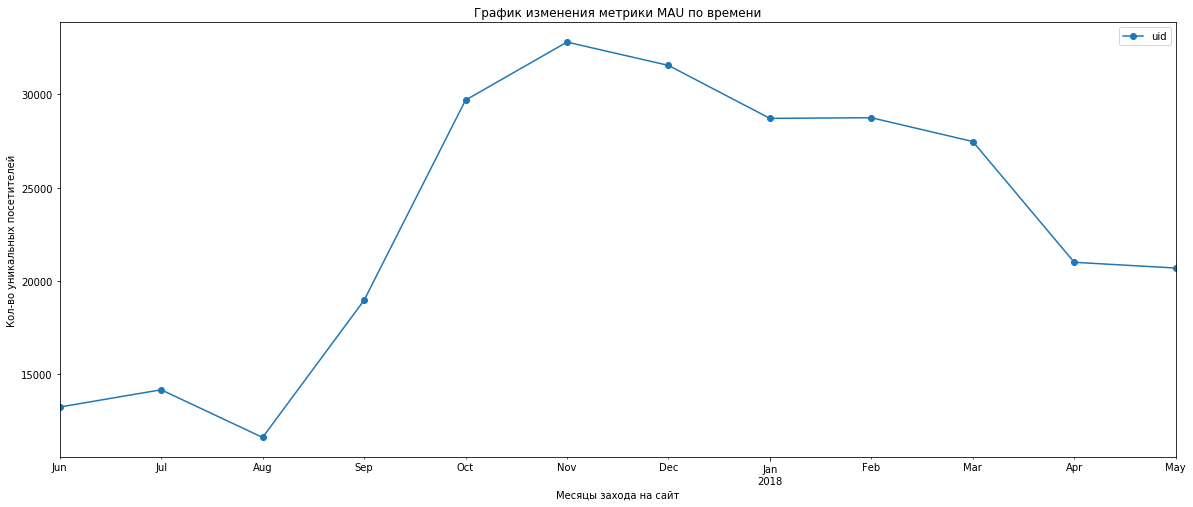

In [24]:
# Построим график MAU 

mau.reset_index().plot(y = 'uid', x = 'session_month', style = 'o-', figsize = (20,8))
plt.title('График изменения метрики MAU по времени')
plt.xlabel('Месяцы захода на сайт')
plt.ylabel('Кол-во уникальных посетителей')

plt.show()

На месячном графике еще более очевидным становится тот факт, что летом посещаемость значительно ниже, чем в другое время. Скорее всего в сезон отпусков, садов и летних прогулок сайт не так актуален.

#### Выясним сколько раз за день пользователи в среднем заходят на сайт

In [25]:
sessions_per_user = visits_log.groupby(['session_month', 'session_date']).agg(
    {'uid': ['count', 'nunique']}
)
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)

print('В среднем пользователи заходят на сайт {} раз в день'. format(sessions_per_user['sessions_per_user'].mean().round(2)))
sessions_per_user.head()

В среднем пользователи заходят на сайт 1.08 раз в день


n_sessions  n_users  sessions_per_user
session_month session_date                                        
2017-06-01    2017-06-01           664      605           1.097521
              2017-06-02           658      608           1.082237
              2017-06-03           477      445           1.071910
              2017-06-04           510      476           1.071429
              2017-06-05           893      820           1.089024

посмотрим как меняется этот показатель со временем

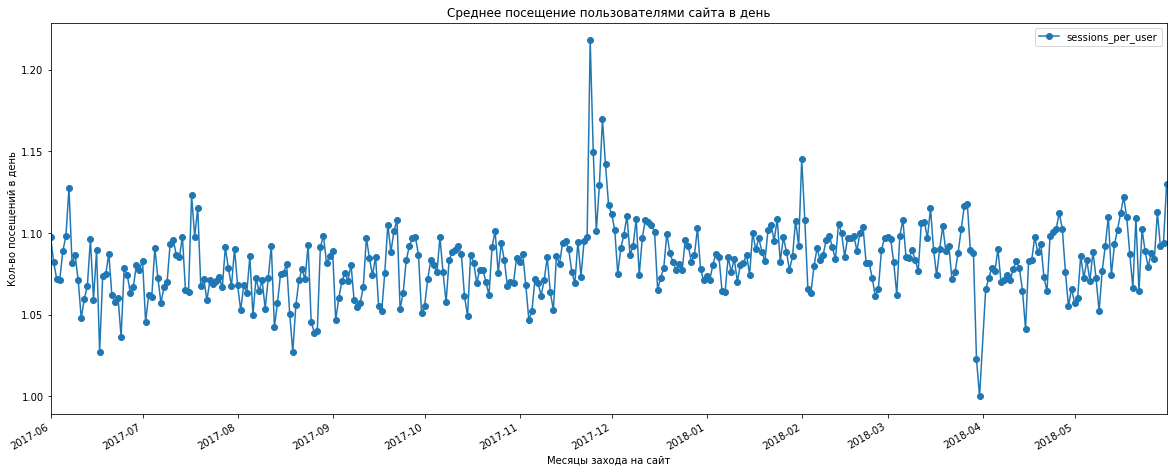

In [26]:
sessions_per_user.reset_index().plot(y = 'sessions_per_user', x = 'session_date', style = 'o-', figsize = (20,8))
plt.title('Среднее посещение пользователями сайта в день')
plt.xlabel('Месяцы захода на сайт')
plt.ylabel('Кол-во посещений в день')

plt.show()

Показатель в течении года практически не менялся. Пользователи заходят на сайт в среднем 1,08 раза в день.

ВЫВОДЫ

Средние значения DAU, WAU и MAU за весь период и их изменение во времени:
    - Daily active users:  907. В целом прослеживается закономерность, что посещение пользователями Яндекс.Афиши в выходные всегда выше, чем в будни.
    - Weekly active users:  5621. По недельным данным можно отметить, что в летнее время и перед новым годом посещаемость ниже, чем в другие недели. 
    - Monthly active users:  23225. На месячном графике еще более очевидным становится тот факт, что летом посещаемость значительно ниже, чем в другое время. 
    - Пользователи заходят на сайт в среднем 1,08 раза в день. Показатель в течении года практически не менялся. 

#### Исследуем, сколько времени пользователи проводят на сайте

Средняя продолжительность сессии или ASL (average session length) показывает, сколько длится сессия пользователя в среднем. Посмотрим сколько она длится в нашем случае.

In [27]:
visits_log['session_duration_sec'] = (
    visits_log['end_ts'] - visits_log['start_ts']
).dt.seconds

print('Медианная продолжительность сессии: {} секунд'. format(visits_log['session_duration_sec'].median().round(2)))
print('Средняя продолжительность сессии: {} секунд'. format(visits_log['session_duration_sec'].mean().round(2)))

Медианная продолжительность сессии: 300.0 секунд
Средняя продолжительность сессии: 643.51 секунд


In [28]:
visits_log['session_duration_sec'].describe()

count    359364.000000
mean        643.510179
std        1016.340888
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

Чтобы выбрать подходящую среднюю меру, построим график распределения.

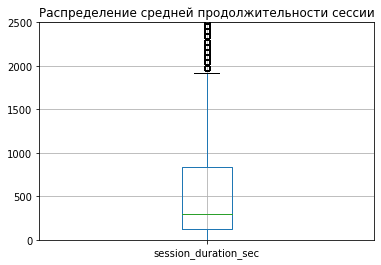

In [29]:
visits_log.boxplot('session_duration_sec') 
plt.title('Распределение средней продолжительности сессии')
plt.ylim(0, 2500)
plt.show()

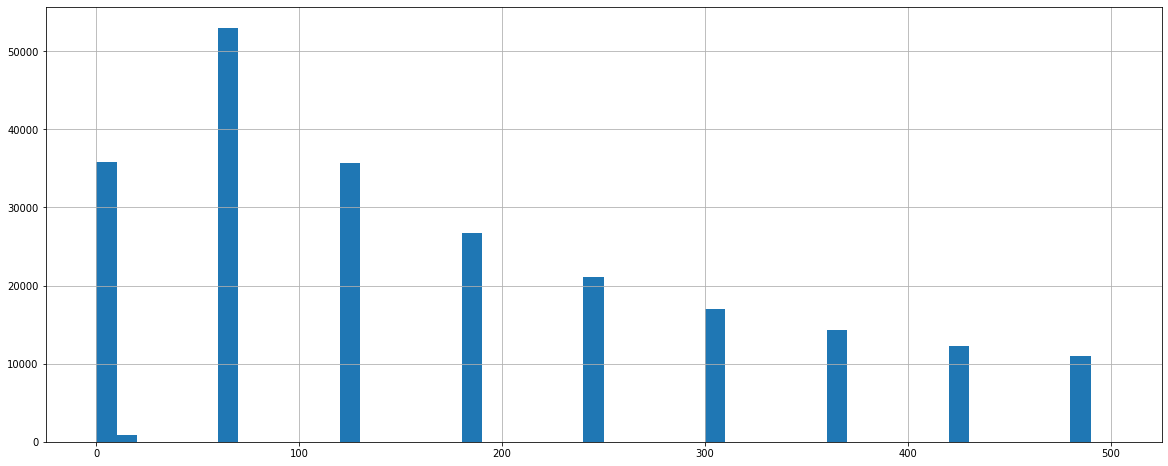

In [30]:
visits_log['session_duration_sec'].hist(bins=50, range = (0,500), figsize = (20, 8))
plt.show()

исходя из графика видно, что длительность нахождения пользователя на сайте округляется до минут.

Посмотрим сколько длится типичная пользовательская сессия. для этого рассчитаем моду — это значение во множестве наблюдений, которое встречается наиболее часто. 

In [31]:
visits_log['session_duration_sec'].mode()

0    60
dtype: int64

Типичная пользовательская сессия длится 1 минуту.

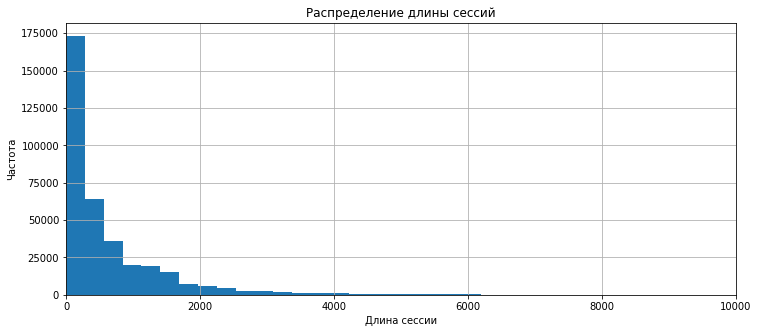

In [32]:
plt.figure(figsize= (12,5))
visits_log['session_duration_sec'].hist(bins=300).set(title = 'Распределение длины сессий', xlabel = 'Длина сессии', ylabel = 'Частота')
plt.xlim(0,10000)
plt.show()

ВЫВОДЫ 

    - В целом, большинство пользователей проводят на сайте от 2 до 14 минут:
    - Медианная продолжительность сессии: 300.0 секунд
    - Средняя продолжительность сессии: 643.51 секунд
    - Однако типичная пользовательская сессия длится 1 минуту. Это очень низкий показатель.

#### Рассчитаем Retention Rate

Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды. Рассчитаем этот показатель.

In [33]:
# вспомним нашу табличку

visits_log.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0


In [34]:
# добавим в таблицу дату первой активности каждого пользователя

first_activity_date  = visits_log.groupby('uid')['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits_log = visits_log.join(first_activity_date, on = 'uid')


In [35]:
# сформируем столбец начала когорты

visits_log['first_month'] = visits_log['first_activity_date'].astype('datetime64[M]')


In [36]:
# построим сводную таблицу

visits_pivot = visits_log.pivot_table(
    index='first_month', 
    columns = 'session_month',
    values = 'uid',
    aggfunc = 'nunique'
)

visits_pivot

session_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_month,,,,,,,,,,,,
2017-06-01,13257.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,NaN,13138.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0
2017-08-01,NaN,NaN,10180.0,782.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0
2017-09-01,NaN,NaN,NaN,16702.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0
2017-10-01,NaN,NaN,NaN,NaN,25973.0,2042.0,1357.0,1011.0,890.0,837.0,555.0,529.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,27247.0,2133.0,1202.0,1054.0,919.0,638.0,594.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,25259.0,1410.0,959.0,786.0,512.0,481.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22621.0,1351.0,890.0,565.0,458.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22196.0,1267.0,565.0,446.0


In [37]:
# Для каждой строки нужно рассчитать lifetime пользователя в рамках когорты

visits_log['cohort_lifetime'] = (
    visits_log['session_month'] - visits_log['first_month']
)
visits_log['cohort_lifetime'] = visits_log[
    'cohort_lifetime'
] / np.timedelta64(1, 'M')


visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'].round().astype('int')



In [38]:
# Сгруппируем данные по когорте и lifetime. 
# Посчитаем для каждой когорты количество активных пользователей на определённый месяц жизни когорты:
    
cohorts = visits_log.groupby(['first_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

cohorts.head()

,first_month,cohort_lifetime,uid
0,2017-06-01,0,13257
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждую следующую неделю.
Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю:


In [39]:
# подготовим срез по столбцу cohort_lifetime = 0 и выберем столбцы first_month и uid:

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_month', 'uid']
]

initial_users_count


,first_month,uid
0,2017-06-01,13257
12,2017-07-01,13138
23,2017-08-01,10180
33,2017-09-01,16702
42,2017-10-01,25973
50,2017-11-01,27247
57,2017-12-01,25259
63,2018-01-01,22621
68,2018-02-01,22196
72,2018-03-01,20588


In [40]:
# Переименуем столбец uid в cohort_users методом rename:

initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 


In [41]:
# Объединим данные по когортам с исходным количеством пользователей в когорте:

cohorts = cohorts.merge(initial_users_count,on='first_month') 


In [42]:
# Рассчитаем Retention Rate. 
# Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте:

cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

cohorts

,first_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13257,13257,1.000000
1,2017-06-01,1,1043,13257,0.078675
2,2017-06-01,2,713,13257,0.053783
3,2017-06-01,3,814,13257,0.061402
4,2017-06-01,4,909,13257,0.068568
...,...,...,...,...,...
73,2018-03-01,1,861,20588,0.041820
74,2018-03-01,2,557,20588,0.027055
75,2018-04-01,0,15708,15708,1.000000
76,2018-04-01,1,760,15708,0.048383


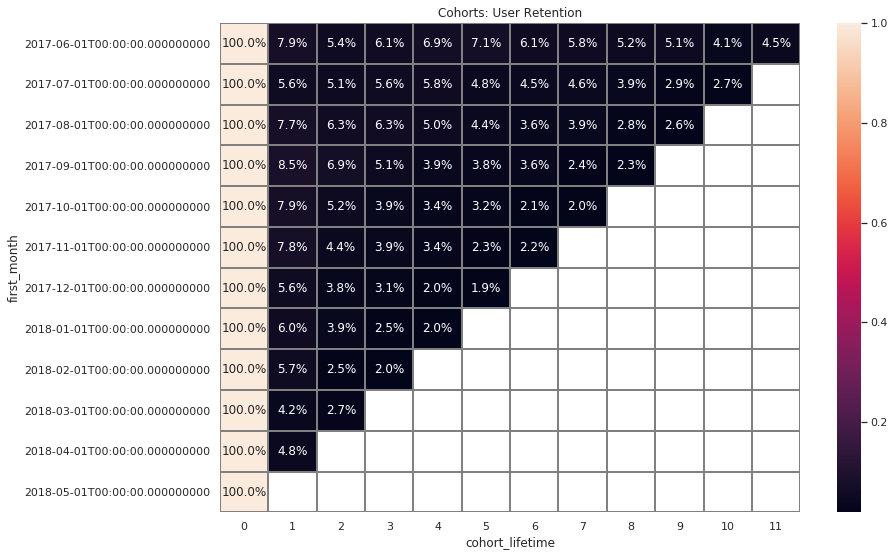

In [43]:
# Построим сводную таблицу и создадим тепловую карту:

retention_pivot = cohorts.pivot_table(
    index='first_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 


In [44]:
Retention_Rate_2 = cohorts[cohorts['cohort_lifetime'] == 1]['retention'].mean().round(4)

print('Cредний Retention Rate на второй месяц «жизни» когорт составляет: {} %'.format(Retention_Rate_2*100))

Cредний Retention Rate на второй месяц «жизни» когорт составляет: 6.52 %


ВЫВОДЫ

Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды. В нашем случае средний Retention Rate на второй месяц «жизни» когорт составляет: 6.52 %. 
Наблюдается очень сильный отток посетителей с сайта после первого месяца - более 93% пользователей заядя однажды на сайт на него больше не заглядывают.

### Метрики электронной коммерции

В этом блоке мы рассмотрим метрики электронной коммерции

    - Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. 
    - Применяя когортный анализ, рассчитаем среднее количество покупок на одного покупателя за 6 месяцев. 
    - Рассчитаем средний чек, применяя группировку по времени совершения покупки. Построим график, отражающий изменения метрики во времени;
    - Выясним, как меняется LTV на покупателя по когортам. Поскольку LTV — накопительная метрика, рассчитаем средний LTV по когортам за 6 месяцев, в расчёт включим когорты, «прожившие» не менее 6 месяцев. Отразим изменения метрики во времени на графике;

Для расчета метрик электронной коммерции необходимо объединить таблицы visits_log с информацией о посещениях сайта и orders_log с информацией о заказах

In [45]:
# выясним источник первого захода на сайт для каждого покупателя

first_source=visits_log.sort_values(by='start_ts').groupby('uid')['source_id'].first().reset_index()
first_source.columns = ['uid', 'first_source']
first_source.head()

,uid,first_source
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


In [46]:
# добавим в таблицу покупок источник первого захода на сайт для каждого покупателя

orders = orders_log.merge(first_source, on = 'uid')
orders.head()

,buy_ts,revenue,uid,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,3


In [47]:
# посмотрим еще раз на табличку

visits_log.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_date,first_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,0


In [48]:
# добавим в таблицу дату первого захода на сайт для каждого покупателя

visits_list = visits_log.groupby('uid')['first_activity_date'].first().reset_index()
visits_list.head()

,uid,first_activity_date
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [49]:
# добавим соответствующий столец в таблицу покупок 

orders = orders.merge(visits_list, on = 'uid', how = 'left')
orders.head()

,buy_ts,revenue,uid,first_source,first_activity_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01 07:31:00


#### Исследуйем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки

In [50]:
# найдем дату совершения первой покупки каждым покупателем

orders_first = orders.groupby('uid')['buy_ts'].first().reset_index()
orders_first = orders_first.merge(visits_list, on = 'uid', how = 'left')
orders_first.head()

,uid,buy_ts,first_activity_date
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [51]:
# узнаем сколько времени прошло с момента первого посещения до первой покупки

orders_first['time_spent'] = orders_first['buy_ts'] - orders_first['first_activity_date']

In [52]:
# узнаем медианное значение

orders_first['time_spent'].median()

Timedelta('0 days 00:16:00')

Медианное время первой покупки на сайте - 16 минут

In [53]:
# посмотрим на данные подробнее

orders_first['time_spent'].describe()

count                      36522
mean     16 days 21:40:50.451782
std      47 days 01:45:35.013558
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:30
max            363 days 07:04:00
Name: time_spent, dtype: object

75% первых покупок совершаются новыми пользователями в течение первых 3 дней.


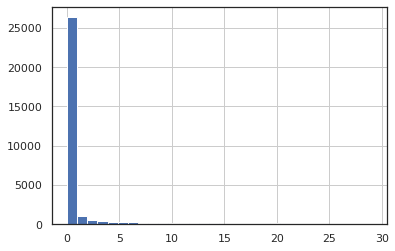

In [54]:
# посмотрим как распределяются первые покупки по дням

orders_first['days']=orders_first['time_spent'].astype('timedelta64[D]')
orders_first['days'].hist(bins=30, range = (0,29))
plt.show()

In [55]:
orders_first['days'].describe()

count    36522.000000
mean        16.730327
std         46.959650
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: days, dtype: float64

Через неделю после первого посещения сайта количесвто первых покупок сильно снижается. Однако есть и такие, кто совершает первую покупку и через год, после первого визита сайта.

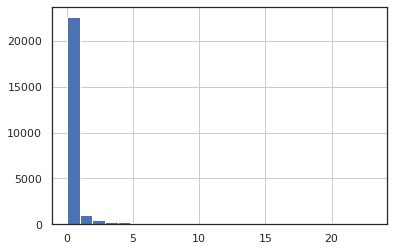

In [56]:
# посмотрим как распределяются первые покупки по часам первого дня

orders_first['hour']=orders_first['time_spent'].astype('timedelta64[h]')
orders_first['hour'].hist(bins=24, range = (0,23))
plt.show()


подавляющее большинство первых покупок совершаются новыми пользователями в течение первого часа прибывания на сайте

большинство тех посетителей, кто приобретают что-то на сайте, делают это в свое первое посещение, причем большинство из них укладываются в 20 минут

Посмотрим на типичное время покупки, для этого рассчитаем моду. 

In [57]:
orders_first['time_spent'].mode()

0   00:01:00
dtype: timedelta64[ns]

Типичное время покупки - 1 минута. Это очень быстро!

####  Рассчитаем среднее количество покупок на одного покупателя за определённый период

Применим когортный анализ для расчета среднего количества покупок на одного покупателя за 6 месяцев. Добавим необходимые столбцы в таблицу : первым месяц захода на сайт и месяц совершения покупки

In [58]:
# первым месяц захода на сайт и месяц совершения покупки

orders['first_month'] = orders['first_activity_date'].astype('datetime64[M]')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

In [59]:
# определим возраст когорты в месяцах для каждой совершенной покупки

orders['cohort_lifetime'] = (
    orders['buy_month'] - orders['first_month']
)
orders['cohort_lifetime'] = orders[
    'cohort_lifetime'
] / np.timedelta64(1, 'M')


orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int')

orders.head()

,buy_ts,revenue,uid,first_source,first_activity_date,first_month,buy_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01 00:09:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01 00:14:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01 00:14:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01 07:31:00,2017-06-01,2017-06-01,0


In [60]:
# Сгруппируем данные по когорте и lifetime. 
# Посчитаем для каждой когорты количество активных покупателей на определённый месяц жизни когорты и количество покупок:
    
order_cohorts = orders.groupby(['first_month','cohort_lifetime']).agg({'revenue':'count','uid':'nunique'}).reset_index() 
order_cohorts['numbers_per_user']=order_cohorts['revenue'] / order_cohorts['uid']
order_cohorts.head(10)

,first_month,cohort_lifetime,revenue,uid,numbers_per_user
0,2017-06-01,0,2354,2023,1.163618
1,2017-06-01,1,387,231,1.675325
2,2017-06-01,2,273,129,2.116279
3,2017-06-01,3,442,188,2.351064
4,2017-06-01,4,516,257,2.007782
5,2017-06-01,5,428,203,2.108374
6,2017-06-01,6,500,189,2.645503
7,2017-06-01,7,329,155,2.122581
8,2017-06-01,8,371,172,2.156977
9,2017-06-01,9,318,156,2.038462


In [61]:
# узнаем среднее количество покупок на 1 покупателя в месяц

print('Среднее количество покупок на 1 покупателя в месяц: ', order_cohorts['numbers_per_user'].mean().round(2))

Среднее количество покупок на 1 покупателя в месяц:  1.43


In [62]:
# посмотрим на сводную таблицу

order_pivot = order_cohorts.pivot_table(
    index='first_month',
    columns='cohort_lifetime',
    values='numbers_per_user',
    aggfunc='sum',
) 
order_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-06-01,1.163618,1.675325,2.116279,2.351064,2.007782,2.108374,2.645503,2.122581,2.156977,2.038462,1.622807,1.760479
2017-07-01,1.127210,1.362963,1.369128,1.272727,1.254902,1.278195,1.163934,1.218750,1.313043,1.208333,1.160000,NaN
2017-08-01,1.117647,1.416667,1.485507,1.529915,1.572816,1.407895,1.342105,1.686047,1.566038,1.448276,NaN,NaN
2017-09-01,1.116526,1.347945,1.365145,1.544944,1.216216,1.371429,1.385714,1.405797,1.204301,NaN,NaN,NaN
2017-10-01,1.135336,1.300420,1.219178,1.192893,1.237374,1.237288,1.129310,1.284553,NaN,NaN,NaN,NaN
2017-11-01,1.165326,1.377698,1.403042,1.732240,1.512438,1.284404,1.356589,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.142653,1.406061,1.386243,1.336898,1.298851,1.274194,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.111952,1.412500,1.457143,1.189873,1.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.116410,1.469751,1.313131,1.311321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В целом видно, что количество покупок на одного пользователя со временем растет.

Отсортируем только те когорты, которые существуют  месяцев и более. для этого нужно взять когорты за первые 6 месяцев годового отчета и отсечь даты покупок более чем за 6 месяцев с момента первого визита сайта.

In [63]:
# отсечем когорты продолжительностью 6 месяцев

orders_more_6 = orders[(orders['first_month'] < '2017-12-01') & (orders['cohort_lifetime'] < 6)]
orders_more_6.head()

,buy_ts,revenue,uid,first_source,first_activity_date,first_month,buy_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01 00:09:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01 00:14:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01 00:14:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01 07:31:00,2017-06-01,2017-06-01,0


In [64]:
# узнаем среднее количество покупок в месяц совершаемых каждым покумателем в месяц по когортам

order_cohorts_more_6 = orders_more_6.groupby(['first_month','cohort_lifetime']).agg({'revenue':'count','uid':'nunique'}).reset_index() 
order_cohorts_more_6['numbers_per_user']=order_cohorts_more_6['revenue'] / order_cohorts_more_6['uid']
order_cohorts_more_6.head()

,first_month,cohort_lifetime,revenue,uid,numbers_per_user
0,2017-06-01,0,2354,2023,1.163618
1,2017-06-01,1,387,231,1.675325
2,2017-06-01,2,273,129,2.116279
3,2017-06-01,3,442,188,2.351064
4,2017-06-01,4,516,257,2.007782


In [65]:
# посчитаем среднее совокупное количество покупок на 1 покупателя за 6 месяцев

order_cohorts_more_6.groupby('first_month').agg({'numbers_per_user':'sum'})

,numbers_per_user
first_month,
2017-06-01,11.422442
2017-07-01,7.665126
2017-08-01,8.530446
2017-09-01,7.962205
2017-10-01,7.322490
2017-11-01,8.475148


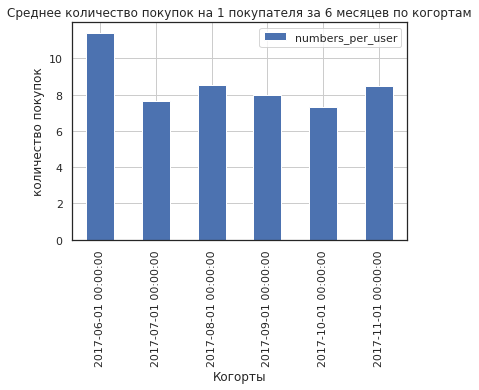

In [66]:
# Построим диаграмму количества покупок на 1 покупателя за 6 месяцев по когортам.

order_cohorts_more_6.groupby('first_month').agg({'numbers_per_user':'sum'}).reset_index().plot(x='first_month', y='numbers_per_user', kind='bar', grid = True)
plt.title('Среднее количество покупок на 1 покупателя за 6 месяцев по когортам')
plt.xlabel('Когорты')
plt.ylabel('количество покупок')
plt.show()

Итак мы видим, что в среднем за 6 месяцев покупатель успевает сделать около 8 покупок, при этом мы видим, что в когорте июня 2017 года активность заметно выше, в ней за 6 месяцев покупатели в среднем сделали более 11 покупок каждый.

#### Рассчитаем средний чек

Рассчитаем средний чек и посмотрим как он меняется по месяцам.

In [67]:
# Рассчитаем средний чек 

aver_check = orders.groupby('first_month').agg({'revenue':'mean'}).reset_index()
print('Средний чек на одного покупателя составлает: ', aver_check['revenue'].mean().round(2))

Средний чек на одного покупателя составлает:  4.89


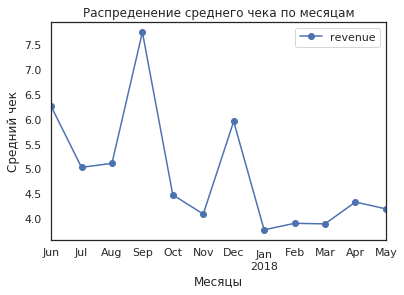

In [68]:
# Построим график вертикальной столбчатой диаграммы среднего чека по месяцам.

# aver_check.plot(x='first_month', y='revenue', kind='bar')
aver_check.plot(x='first_month', y='revenue', style='-o')
plt.title('Распреденение среднего чека по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Средний чек')
plt.show()

Из графика видно, что самый высокий средний чек наблюдался в сентябре, также выше среднего средний чек в июне и декабре. самые низкие показатели с января по март.

#### Выясним, как меняется LTV на покупателя по когортам

LTV (lifetime value) — «пожизненная» ценность клиента. Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. При расчёте LTV обычно обращаются к валовой прибыли с клиента за период.

Выясним, как меняется LTV на покупателя по когортам. Поскольку LTV — накопительная метрика, рассчитаем средний LTV по когортам за 6 месяцев. 

Маржинальность сервиса — 100%, значит в нашем случае валовая прибыль равна выручке. 

Отразим изменения метрики во времени на графике. 

In [69]:
cohorts

,first_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13257,13257,1.000000
1,2017-06-01,1,1043,13257,0.078675
2,2017-06-01,2,713,13257,0.053783
3,2017-06-01,3,814,13257,0.061402
4,2017-06-01,4,909,13257,0.068568
...,...,...,...,...,...
73,2018-03-01,1,861,20588,0.041820
74,2018-03-01,2,557,20588,0.027055
75,2018-04-01,0,15708,15708,1.000000
76,2018-04-01,1,760,15708,0.048383


In [70]:
# Чтобы построить когортный отчет, нужно определить дату и время первой сессии каждого пользователя.
first_visits = visits_log.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'first_session_start_ts']

# для удобства группировки, добавим колонки даты и месяца
first_visits['first_session_dt'] = first_visits['first_session_start_ts'].dt.date
first_visits['first_session_month'] = first_visits['first_session_start_ts'].astype('datetime64[M]')

first_visits


,uid,first_session_start_ts,first_session_dt,first_session_month
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01
4,325320750514679,2017-09-30 14:29:00,2017-09-30,2017-09-01
...,...,...,...,...
228135,18446403737806311543,2017-11-30 03:36:00,2017-11-30,2017-11-01
228136,18446424184725333426,2017-12-06 20:32:00,2017-12-06,2017-12-01
228137,18446556406699109058,2018-01-01 16:29:00,2018-01-01,2018-01-01
228138,18446621818809592527,2017-12-27 13:27:00,2017-12-27,2017-12-01


In [71]:
# Найдем время первой покупки каждого покупателя
orders_log['order_month'] = orders_log['buy_ts'].astype('datetime64[M]')
first_orders = orders_log.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_ts']
first_orders['first_order_dt'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')

# объединяем данные о первых покупках с данными о первых сессиях
buyers = pd.merge(first_visits, first_orders, on='uid')
buyers

,uid,first_session_start_ts,first_session_dt,first_session_month,first_order_ts,first_order_dt,first_order_month
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-03,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-03,2017-06-01
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-11,2017-10-01
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-28,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-24,2017-11-01
...,...,...,...,...,...,...,...
36517,18445147675727495770,2017-08-20 13:30:00,2017-08-20,2017-08-01,2017-11-24 09:03:00,2017-11-24,2017-11-01
36518,18445407535914413204,2017-09-22 23:48:00,2017-09-22,2017-09-01,2017-09-22 23:55:00,2017-09-22,2017-09-01
36519,18445601152732270159,2017-08-07 11:51:00,2017-08-07,2017-08-01,2018-03-26 22:54:00,2018-03-26,2018-03-01
36520,18446156210226471712,2017-11-07 10:01:00,2017-11-07,2017-11-01,2018-02-18 19:34:00,2018-02-18,2018-02-01


In [72]:
# Найдем число покупателей в каждой когорте (коготры считаются с первого визита пользователя на сайт)
cohort_sizes = buyers.groupby('first_session_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)

# Добавим в информацию о покупках месяц первой покупки
cohorts = pd.merge(orders_log, buyers, how='inner', on='uid')\
            .groupby(['first_session_month', 'order_month'])\
            .agg({'revenue': 'sum'}).reset_index()

# Считаем возраст каждой когорты
cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_session_month']) / np.timedelta64(1,'M')).round()
cohorts.columns = ['first_session_month', 'order_month', 'revenue', 'age_month']

cohorts.head()


,first_session_month,order_month,revenue,age_month
0,2017-06-01,2017-06-01,9557.49,0.0
1,2017-06-01,2017-07-01,2664.58,1.0
2,2017-06-01,2017-08-01,1464.69,2.0
3,2017-06-01,2017-09-01,3882.09,3.0
4,2017-06-01,2017-10-01,3940.59,4.0


In [73]:
# Добавляем в когортный отчет количество покупателей в каждой когорте 
# и считаем выручку на каждого покупателя.
cohorts_report = pd.merge(cohort_sizes, cohorts, on = 'first_session_month')
cohorts_report['ltv'] = cohorts_report['revenue'] / cohorts_report['n_buyers']

# Возростной когортный отчет, показывающий накопительную выручку на покупателя

cohorts_age = cohorts_report.pivot_table(
    index='first_session_month', 
    columns='age_month', 
    values='ltv', 
    aggfunc='sum'
).cumsum(axis=1)

cohorts_age.round(2).fillna('')




age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_session_month,,,,,,,,,,,,
2017-06-01,3.27,4.18,4.68,6.01,7.36,8.32,9.52,10.3,11.09,12.28,13.03,13.69
2017-07-01,4.02,4.45,4.9,5.3,5.64,5.97,6.21,6.52,6.82,7.06,7.25,
2017-08-01,3.62,4.20,4.79,5.34,5.81,6.12,6.4,7.12,7.61,7.83,,
2017-09-01,4.04,5.25,5.94,9.35,9.78,10.4,10.72,10.88,11.01,,,
2017-10-01,3.93,4.74,5.02,5.25,5.47,5.69,5.81,5.96,,,,
2017-11-01,3.88,4.50,4.82,5.14,5.4,5.57,5.73,,,,,
2017-12-01,4.14,4.56,5.6,6.85,7.21,7.65,,,,,,
2018-01-01,3.40,4.02,4.4,4.49,4.66,,,,,,,
2018-02-01,3.61,4.24,4.44,4.73,,,,,,,,


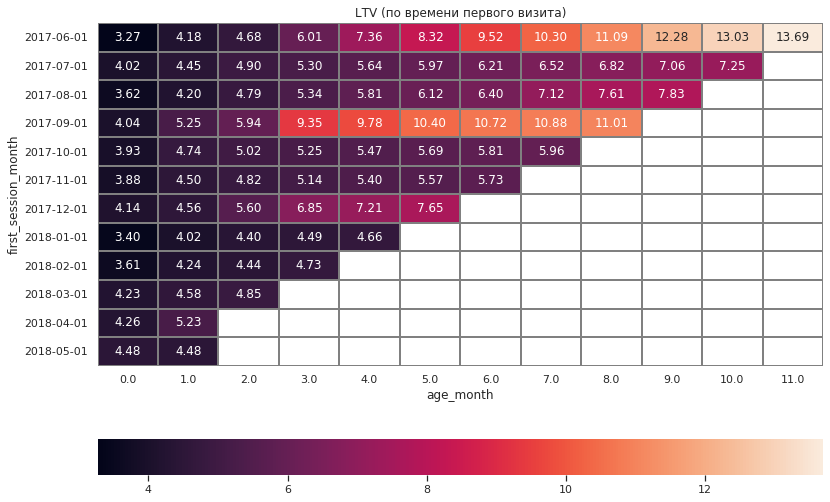

In [74]:
plt.figure(figsize=(13, 9))
sns.heatmap(cohorts_age, annot=True, fmt='.2f', linewidths=1, linecolor='grey', cbar_kws= {'orientation': 'horizontal'} 
            ).set(title ='LTV (по времени первого визита)', yticklabels = cohorts_age.index.astype('str'))
plt.show()

In [75]:
print("Средний LTV за 6 месяцев:", round(cohorts_age[5].mean(),2))

Средний LTV за 6 месяцев: 7.1


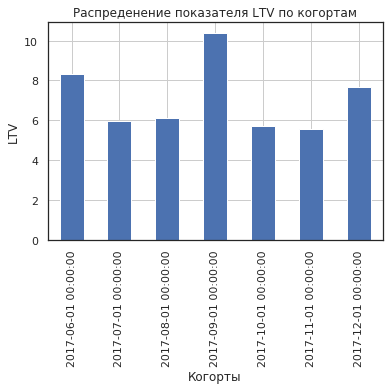

In [76]:
# Построим диаграмму показателя ltv за 6 месяцев по когортам.

cohorts_age[5].dropna().plot(kind='bar', grid = True)
plt.title('Распреденение показателя LTV по когортам')
plt.xlabel('Когорты')
plt.ylabel('LTV')
plt.show()

Самый высокий показатель метрики LTV (lifetime value) оказался у когорты сентября 2017, его значение около 11 условных единиц.

ВЫВОДЫ

    - Медианное время первой покупки на сайте - 16 минут. 75% первых покупок совершаются новыми пользователями в течение первых 3 дней. Через неделю после первого посещения сайта количесвто первых покупок сильно снижается. Однако есть и такие, кто совершает первую покупку и через год, после первого визита сайта.
    - Среднее количество покупок на 1 покупателя в месяц:  1.43
    - В среднем за 6 месяцев покупатель успевает сделать около 8 покупок, при этом мы видим, что в когорте июня 2017 года активность заметно выше, в ней за 6 месяцев покупатели в среднем сделали более 11 покупок.
    - Средний чек на одного покупателя составлает:  4.89. Самый высокий средний чек наблюдался в сентябре, также выше среднего средний чек в сентябре и декабре. самые низкие показатели с января по март.
    - Из когорт, «проживших» не менее 6 месяцев, самый высокий показатель метрики LTV (lifetime value) оказался у когорты сентября 2017, его значение около 11 условных единиц.
    
  

### Маркетинговые метрики

В этом блоке рассмотрим маркетинговые метрики.

    - Посчитаем и отобразим на графиках, как маркетинговые метрики различаются по рекламным источникам. Поскольку один и тот же пользователь мог заходить на сайт из нескольких источников, поэтому важно определить «главный» источник для каждого и учитывать это в расчётах. 
    - Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени;
    - Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразим изменения метрик на графиках;
    - Рассчитаем ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт. Обратим внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Построим графики, отражающие изменения метрик во времени.


#### Посчитаем общую сумму расходов на маркетинг.

Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени;

In [77]:
# посмотрим на таблицу затрат

costs.tail()

,source_id,dt,costs
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15
2541,10,2018-05-31,17.60


In [78]:
# оценим суммарные затраты на маркетинг 

print('Суммарные затраты на маркетинг за год: ', costs['costs'].sum())

Суммарные затраты на маркетинг за год:  329131.62


In [79]:
# соберем расходы по дням в группировку по месяцам, для этого нужно ввести новый столбец

costs['costs_month'] = costs['dt'].astype('datetime64[M]')

In [80]:
# посчитаем затраты по месяцам и полные затраты

monthly_costs = costs.groupby('costs_month')['costs'].sum().reset_index()
monthly_costs

,costs_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


посмотрим как менялись затраты по месяцам на графике

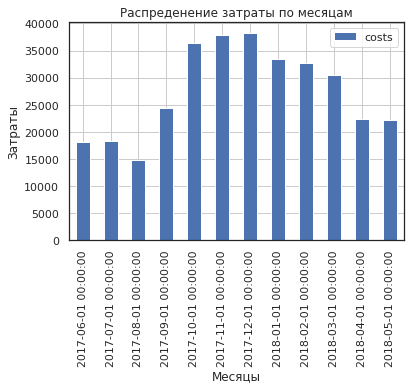

In [81]:
monthly_costs.plot(x='costs_month', y='costs', kind='bar', grid = True)
plt.title('Распреденение затраты по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Затраты')
plt.show()

В летние периоды затраты на маркетинг не превышали 18500б начиная с сентября затраты увеличивались и составили более 35000 с октября по декабрь включительно.в первом квартале 2018 г. этот параметр не превышал 30-33,5 тысяч и в артеле-мае составил чуть более 22000 каждый месяц.

Посмотрим как распределились затраты по рекламным источникам

In [82]:
source_costs = costs.groupby('source_id')['costs'].sum().reset_index()
source_costs

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Лидер по затратам - рекламный источник №3, более 43% от общего бюджета на маркетинг. Меньше всего потратили на источники 9 и 10 - менее 6000 на каджый.

#### Рассчитаем средний CAC на одного покупателя

CAC (customer acquisition cost) — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании. 

Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразите изменения метрик на графиках.

In [83]:
# добавим столбец с размером когорты

cohort_sizes_all = orders.groupby('first_month').agg({'uid':'nunique'})
cohort_sizes_all.columns = ['n_buyers']
monthly_costs = monthly_costs.merge(cohort_sizes_all, left_on='costs_month', right_on='first_month')
monthly_costs

,costs_month,costs,n_buyers
0,2017-06-01,18015.00,2923
1,2017-07-01,18240.59,2458
2,2017-08-01,14790.54,1720
3,2017-09-01,24368.91,3058
4,2017-10-01,36322.88,4678
5,2017-11-01,37907.88,4262
6,2017-12-01,38315.35,4074
7,2018-01-01,33518.52,3119
8,2018-02-01,32723.03,3186
9,2018-03-01,30415.27,2838


In [84]:
# Найдем значения САС для каждой когорты покупателей

monthly_costs['cac'] = monthly_costs['costs'] / monthly_costs['n_buyers']

In [85]:
# посмотрим среднее значение 

print('Средняя стоимость привлечения клиента: ', monthly_costs['cac'].mean().round(2))

Средняя стоимость привлечения клиента:  9.11


In [86]:
# посмотрим на таблицу

monthly_costs

,costs_month,costs,n_buyers,cac
0,2017-06-01,18015.00,2923,6.163189
1,2017-07-01,18240.59,2458,7.420907
2,2017-08-01,14790.54,1720,8.599151
3,2017-09-01,24368.91,3058,7.968905
4,2017-10-01,36322.88,4678,7.764617
5,2017-11-01,37907.88,4262,8.894388
6,2017-12-01,38315.35,4074,9.404848
7,2018-01-01,33518.52,3119,10.746560
8,2018-02-01,32723.03,3186,10.270882
9,2018-03-01,30415.27,2838,10.717149


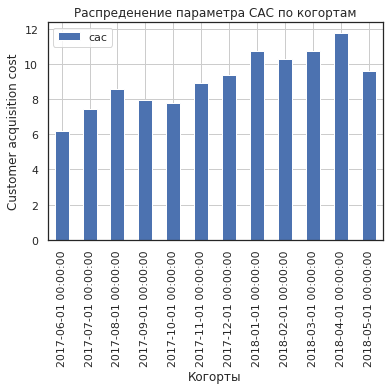

In [87]:
# посмотрим на метрику САС для наших когорт с жизнью от 6 месяцев на графике

monthly_costs.plot(x='costs_month', y='cac', kind='bar', grid = True)
plt.title('Распреденение параметра САС по когортам')
plt.xlabel('Когорты')
plt.ylabel('Сustomer acquisition cost')
plt.show()

Самая высокая стоимость привлечения одного клиента оказалачь в когорте апреля 2018 года - 11,78 за одного клиента, самая низкая - в июне, 6,99 за одного клиента. Стоимость привлечения одного клиента растет с каждой когортой!

Рассчитаем средний CAC для каждого источника трафика, для этого необходимо найти для каждого покупателя первоначальный источник, который привел его на сайт. 

In [88]:
# посмотрим на таблицу orders

orders.head()

,buy_ts,revenue,uid,first_source,first_activity_date,first_month,buy_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01 00:09:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01 00:14:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01 00:14:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01 07:31:00,2017-06-01,2017-06-01,0


In [89]:
# найдем количество клиентов пришедших впервые по каджому источнику

source_sizes = orders.groupby('first_source').agg({'uid':'nunique'})
source_sizes.columns = ['n_source']
source_sizes.reset_index()

,first_source,n_source
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,9,1088
6,10,1329


In [90]:
# добавим соответствующий столбец в талбицу затрат по каждому источнику

source_costs = source_costs.merge(source_sizes, left_on='source_id', right_on='first_source', how='left')
source_costs


,source_id,costs,n_source
0,1,20833.27,2899
1,2,42806.04,3506
2,3,141321.63,10473
3,4,61073.60,10296
4,5,51757.10,6931
5,9,5517.49,1088
6,10,5822.49,1329


Наибольшее количество клиентов привлекли 3 и 4 рекламные источники - более, чем по 10000 человек, 9 и 10 привлекли немногим больше 1000 клиентов - это наименьший результат.

In [91]:
# найдем показатель САС по каждому источнику трафика

source_costs['cac'] = source_costs['costs'] / source_costs['n_source']
source_costs

,source_id,costs,n_source,cac
0,1,20833.27,2899,7.186364
1,2,42806.04,3506,12.209367
2,3,141321.63,10473,13.493901
3,4,61073.60,10296,5.931779
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1329,4.381106


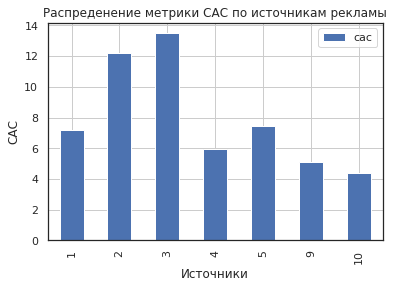

In [92]:
# построим график распределения САС по источникам

source_costs.plot(x='source_id', y='cac', kind='bar', grid = True)
plt.title('Распреденение метрики САС по источникам рекламы')
plt.xlabel('Источники')
plt.ylabel('САС')
plt.show()

Самая высокая стоимость привлечения клиента 13,5 - у источника №3, немного отстает №2 с показателем 12.2. Самые низкие стоимости у источников 9 и 10 - 5,07 и 4,38 соответственно

#### Рассчитаем показатель ROMI 

ROMI (Return on Marketing Investment) — коэффициент возврата инвестиций, показывающий рентабельность вложений. В процентном соотношении он демонстрирует прибыльность (при значении больше 100%) или убыточность (при значении меньше 100%) маркетингового канала.

Другими словами, этот коэффициент показывает, насколько эффективно были вложены деньги в рекламу.

Рассчитаем ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт. 

Возьмем во внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Построим графики, отражающие изменения метрик во времени.

**для понимания коэффициента возврата инвестиций, в течение 6 месяцев, имеет смысл брать в рассчет первые 6 месяцев из данных, чтобы видеть сколько денег в последующие 6 месяцев принесли данные вложения в маркетинг**

In [93]:
orders.head()

,buy_ts,revenue,uid,first_source,first_activity_date,first_month,buy_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01 00:09:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01 00:14:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01 00:14:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01 07:31:00,2017-06-01,2017-06-01,0


In [94]:
total=orders[['revenue','first_source','first_month', 'buy_month', 'cohort_lifetime', 'uid']]
total.columns=['revenue','source_id','cohort', 'buy_month', 'age', 'n_buyers']
total=total.groupby(['cohort','source_id','age']).agg({'revenue':'sum','n_buyers':'nunique'}).reset_index()
total

,cohort,source_id,age,revenue,n_buyers
0,2017-06-01,1,0,1378.70,190
1,2017-06-01,1,1,662.73,29
2,2017-06-01,1,2,683.12,20
3,2017-06-01,1,3,1613.45,22
4,2017-06-01,1,4,1055.58,19
...,...,...,...,...,...
534,2018-05-01,4,0,2516.80,610
535,2018-05-01,4,1,3.42,1
536,2018-05-01,5,0,1697.01,406
537,2018-05-01,9,0,83.82,30


In [95]:

source_tot = costs.groupby(['costs_month','source_id']).agg({'costs':'sum'}).reset_index()
source_tot.columns = ['cohort','source_id','costs']
source_tot

,cohort,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


In [96]:
total=total.merge(source_tot, on=['cohort','source_id'], how='left')
total

,cohort,source_id,age,revenue,n_buyers,costs
0,2017-06-01,1,0,1378.70,190,1125.61
1,2017-06-01,1,1,662.73,29,1125.61
2,2017-06-01,1,2,683.12,20,1125.61
3,2017-06-01,1,3,1613.45,22,1125.61
4,2017-06-01,1,4,1055.58,19,1125.61
...,...,...,...,...,...,...
534,2018-05-01,4,0,2516.80,610,4214.21
535,2018-05-01,4,1,3.42,1,4214.21
536,2018-05-01,5,0,1697.01,406,3669.56
537,2018-05-01,9,0,83.82,30,362.17


In [97]:
total['ltv'] = total['revenue'] / total['n_buyers']
total['cac'] = total['costs'] / total['n_buyers']
total['romi'] = total['ltv'] / total['cac']
total

,cohort,source_id,age,revenue,n_buyers,costs,ltv,cac,romi
0,2017-06-01,1,0,1378.70,190,1125.61,7.256316,5.924263,1.224847
1,2017-06-01,1,1,662.73,29,1125.61,22.852759,38.814138,0.588774
2,2017-06-01,1,2,683.12,20,1125.61,34.156000,56.280500,0.606889
3,2017-06-01,1,3,1613.45,22,1125.61,73.338636,51.164091,1.433401
4,2017-06-01,1,4,1055.58,19,1125.61,55.556842,59.242632,0.937785
...,...,...,...,...,...,...,...,...,...
534,2018-05-01,4,0,2516.80,610,4214.21,4.125902,6.908541,0.597218
535,2018-05-01,4,1,3.42,1,4214.21,3.420000,4214.210000,0.000812
536,2018-05-01,5,0,1697.01,406,3669.56,4.179828,9.038325,0.462456
537,2018-05-01,9,0,83.82,30,362.17,2.794000,12.072333,0.231438


In [98]:
def romi_by_source(source):
    romi_i = total.query('source_id == @source')\
        .pivot_table(index='cohort', columns='age', values='romi', aggfunc='sum')\
        .cumsum(axis=1)
#     print()
    return (romi_i.round(2))

In [99]:
# Посмотрим на тепловую карту для ROMI каждого источника в разрезе когорт

# for i in total['source_id'].unique():
def romi_by_source(i):
    romi_i= total.query('source_id == @i')\
        .pivot_table(index='cohort', columns='age', values='romi', aggfunc='sum')\
        .cumsum(axis=1).round(2)
    print('Посмотрим на тепловую карту для ROMI {}-го источника'.format(i))
    plt.figure(figsize=(20, 8))
    plt.title('ROMI - источник {}'.format(i))
    sns.heatmap(romi_i, annot=True, fmt=".2f", linewidths=.5,
        yticklabels=romi_i.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
    plt.xlabel('Возраст когорты')
    plt.ylabel('Когорта')
    plt.show()
    
    print('Посмотрим как ведет себя показатель ROMI для {}-го источника в разных когортах'.format(i))
    a = romi_i.transpose()
    x=range(len(a))
    for col in a.columns:
        plt.plot(x, a[col])
#     plt.legend()
    plt.grid()    
    plt.xlabel('Возраст когорты')
    plt.ylabel('ROMI - источник {}'.format(i))
    plt.show()
    
    print('Посмотрим на ROMI для {}-го источника в разных когортах за 6 месяцев'.format(i))
    romi_i[5].dropna().plot(kind='bar', grid = True)
    plt.title('Распреденение показателя ROMI для источника {} за 6 месяцев по когортам'.format(i))
    plt.xlabel('Когорты')
    plt.ylabel('ROMI')
    plt.show()
    
    print("Средний ROMI за 6 месяцев по источнику {} - ".format(i), round(romi_i[5].mean(),2))

Посмотрим на тепловую карту для ROMI 1-го источника


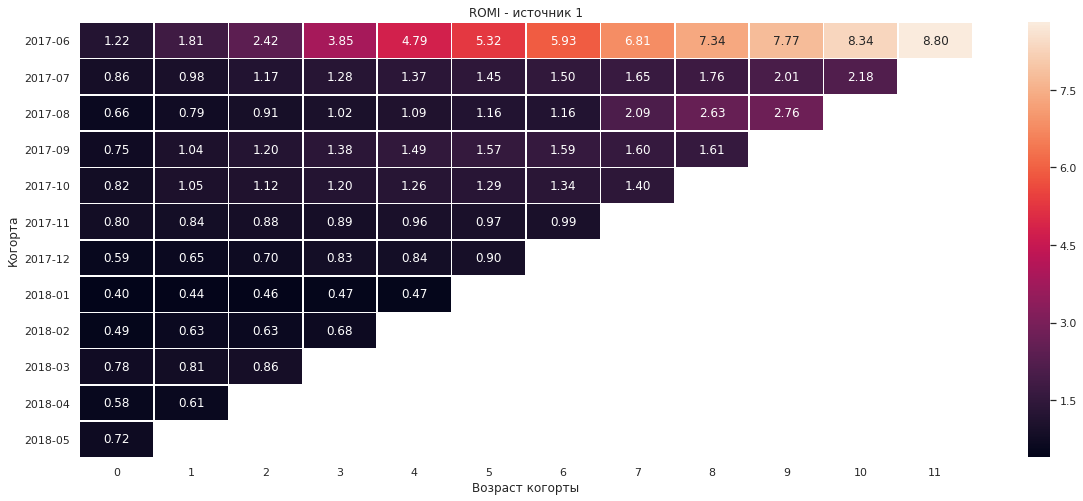

Посмотрим как ведет себя показатель ROMI для 1-го источника в разных когортах


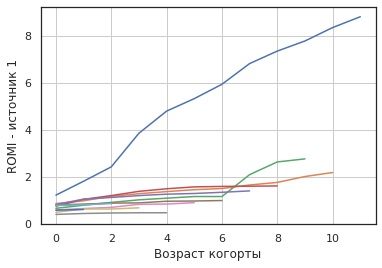

Посмотрим на ROMI для 1-го источника в разных когортах за 6 месяцев


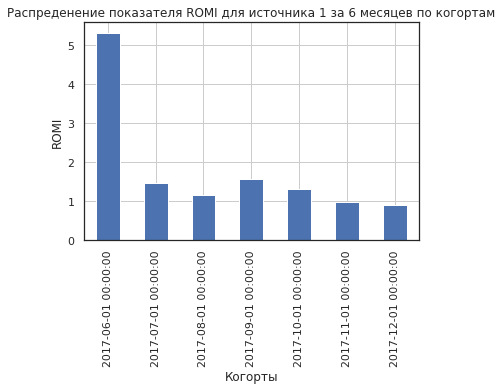

Средний ROMI за 6 месяцев по источнику 1 -  1.81


In [100]:
romi_by_source(1)

**Источник №1** за 6 месяцев крайне редко опускался ниже 1. Средний ROMI за 6 месяцев по источнику 1 -  1.81. Это неплохой показатель и вложения в этот источник окупаются. Однако стоит отметить, что с каждой последующей когортой показатель становится хуже, возможно нужно поменять рекламный макет/посыл. 

Посмотрим на тепловую карту для ROMI 2-го источника


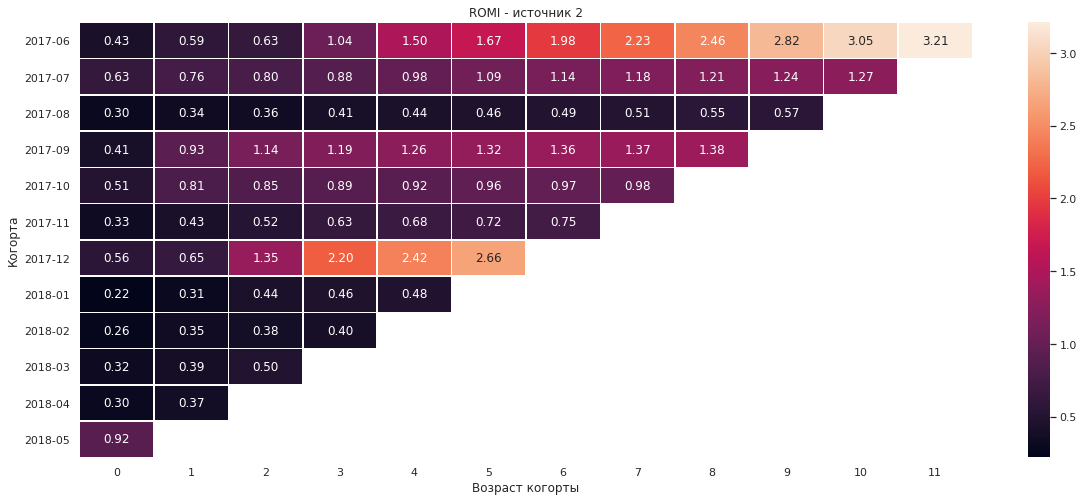

Посмотрим как ведет себя показатель ROMI для 2-го источника в разных когортах


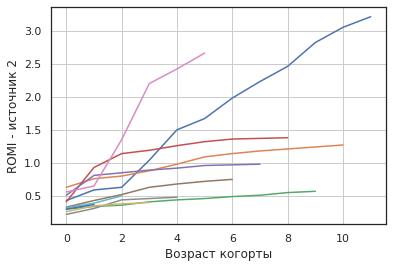

Посмотрим на ROMI для 2-го источника в разных когортах за 6 месяцев


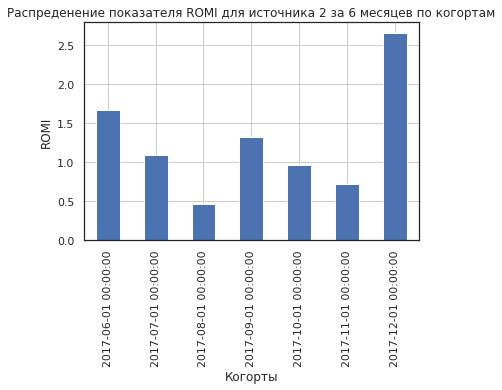

Средний ROMI за 6 месяцев по источнику 2 -  1.27


In [101]:
romi_by_source(2)

**Источник №2** не приносит много прибыли, иногда он даже не окупается за 6 месяцев. Однако в последней наблюдаемой когорте мы видим рост, возможно отдел маркетинга сменил подачу рекламы, пока этот источник можно оставить

Посмотрим на тепловую карту для ROMI 3-го источника


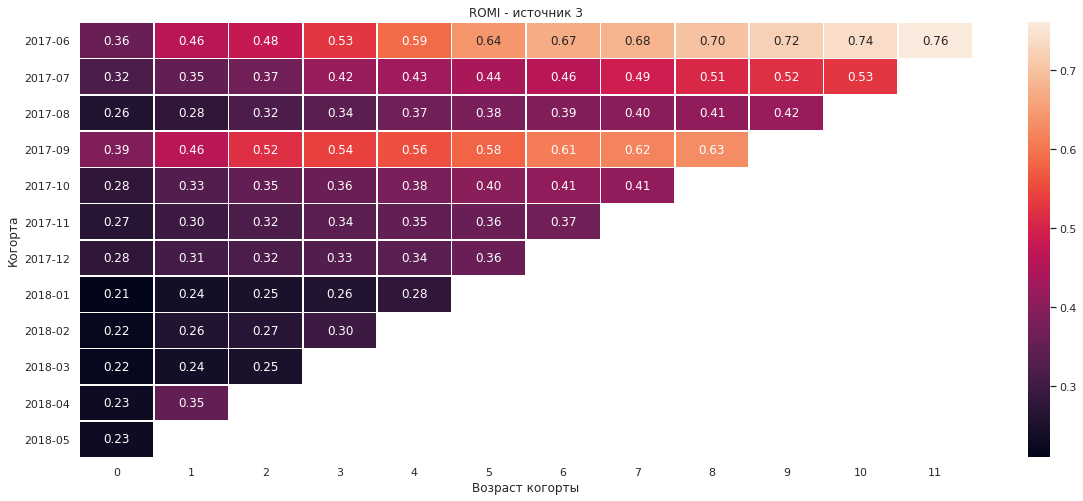

Посмотрим как ведет себя показатель ROMI для 3-го источника в разных когортах


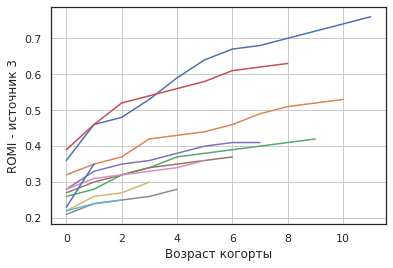

Посмотрим на ROMI для 3-го источника в разных когортах за 6 месяцев


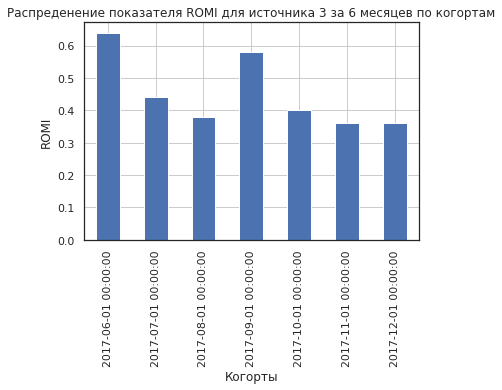

Средний ROMI за 6 месяцев по источнику 3 -  0.45


In [102]:
romi_by_source(3)

**Источник №3** убыточен, его не стоит использовать.

Посмотрим на тепловую карту для ROMI 4-го источника


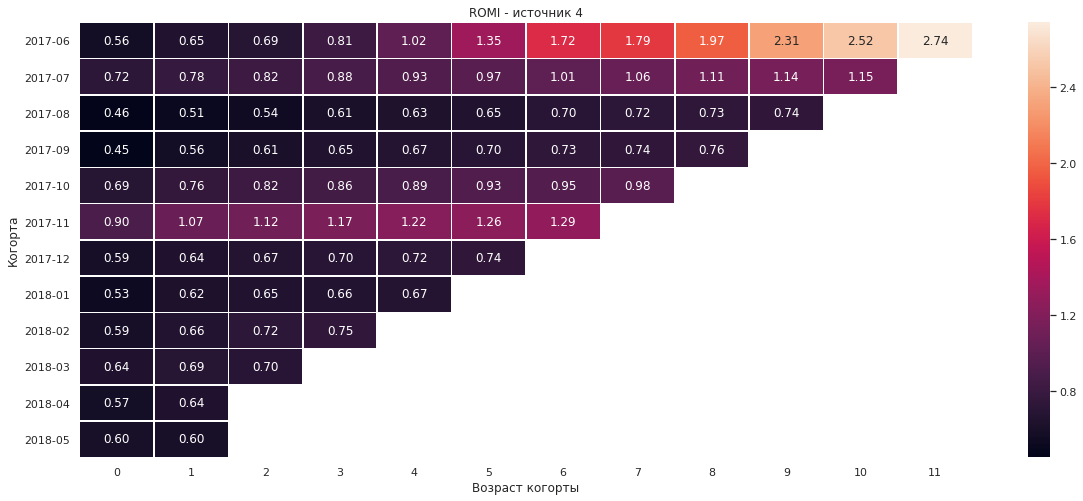

Посмотрим как ведет себя показатель ROMI для 4-го источника в разных когортах


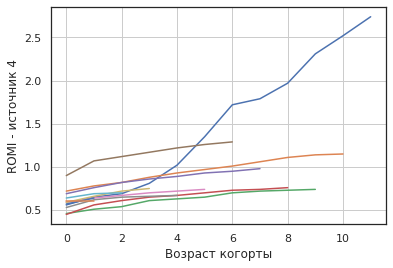

Посмотрим на ROMI для 4-го источника в разных когортах за 6 месяцев


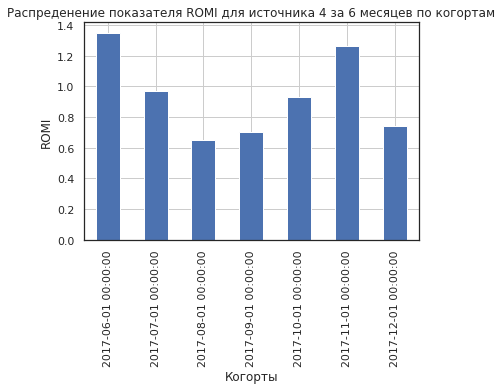

Средний ROMI за 6 месяцев по источнику 4 -  0.94


In [103]:
romi_by_source(4)

**Источник №4** в целом убыточен, однако в некоторые месяцы он приносил прибыль (две когорты из 6 окупили вложения). На графике прослеживается некая закономерность, возможно просадка в отдаче этого источника рекламы имеет сезонность. 

Посмотрим на тепловую карту для ROMI 5-го источника


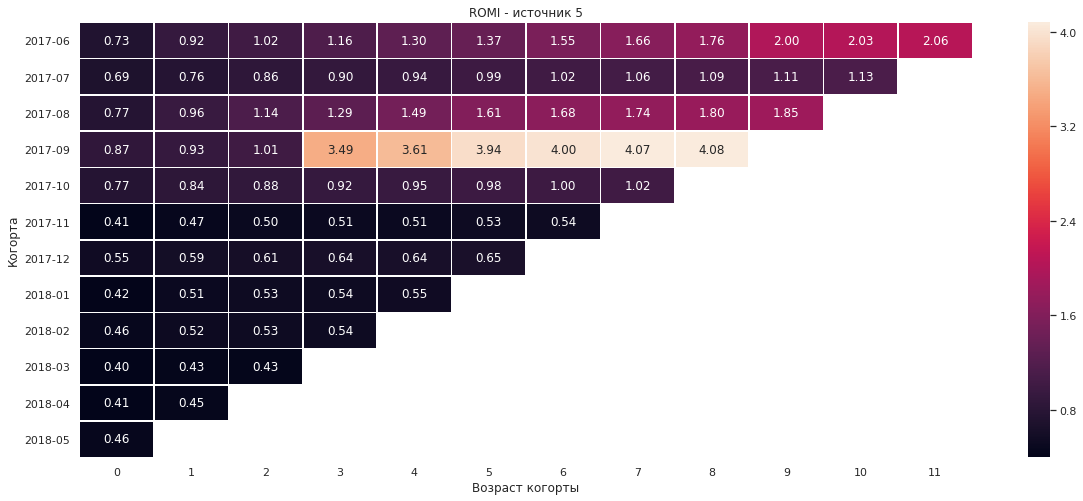

Посмотрим как ведет себя показатель ROMI для 5-го источника в разных когортах


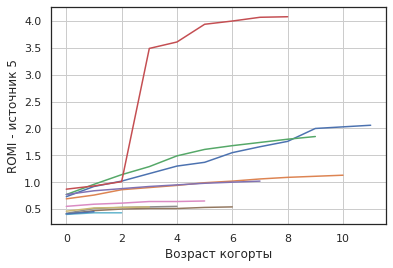

Посмотрим на ROMI для 5-го источника в разных когортах за 6 месяцев


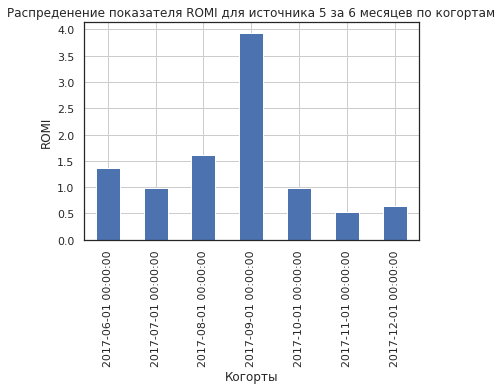

Средний ROMI за 6 месяцев по источнику 5 -  1.44


In [104]:
romi_by_source(5)

**Источник №5** не окупился лишь дважды за 6 месяцев, это неплохой рекламный источник, его можно использовать. Однако стоит обратить внимание на посыл рекламы в ноябре и декабре, эти 2 месяца значительно отстали, возможно реклама в эти месяцы отличалась.

Посмотрим на тепловую карту для ROMI 9-го источника


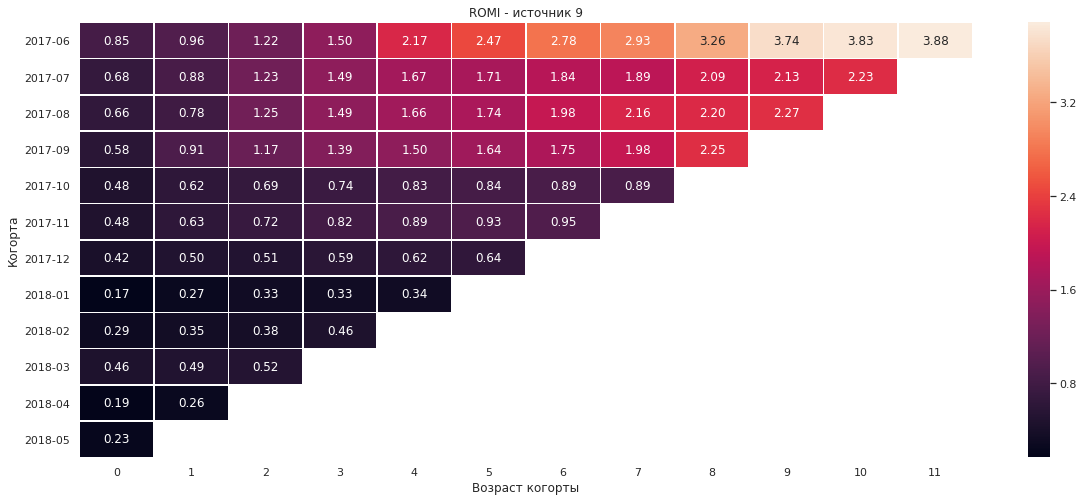

Посмотрим как ведет себя показатель ROMI для 9-го источника в разных когортах


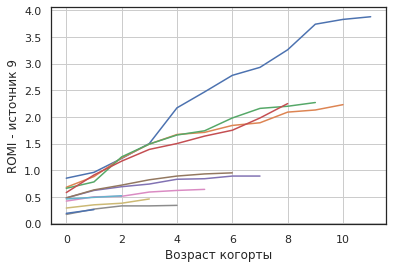

Посмотрим на ROMI для 9-го источника в разных когортах за 6 месяцев


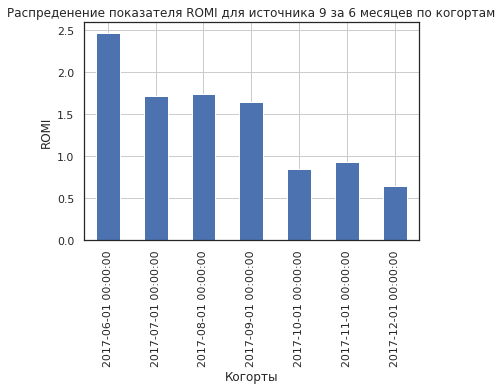

Средний ROMI за 6 месяцев по источнику 9 -  1.42


In [105]:
romi_by_source(9)

**Источник №9** снасала показывал себя очень хорошо, однако отдача от него снижается - нужно проанализировать почему. Возможно, имеет место сезонность источника или подача рекламы. Его можно использовать, когда поймем почему наблюдается просадка

Посмотрим на тепловую карту для ROMI 10-го источника


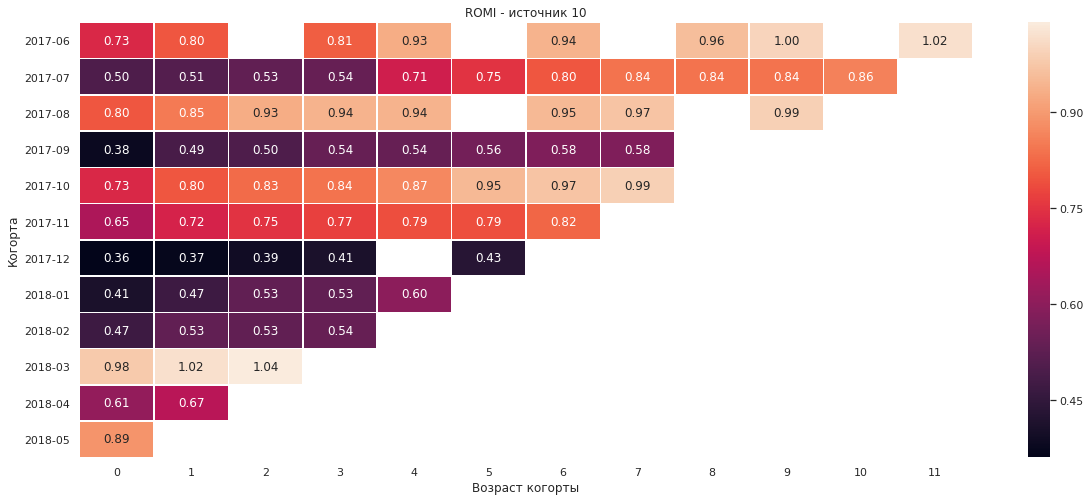

Посмотрим как ведет себя показатель ROMI для 10-го источника в разных когортах


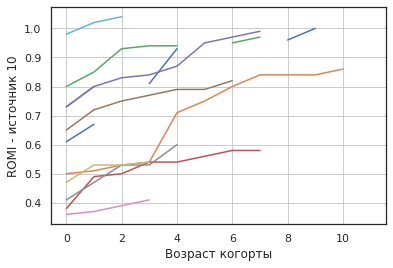

Посмотрим на ROMI для 10-го источника в разных когортах за 6 месяцев


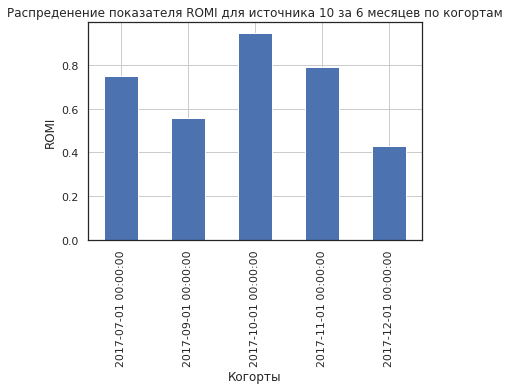

Средний ROMI за 6 месяцев по источнику 10 -  0.7


In [106]:
romi_by_source(10)

**Источник №10** убыточен, его не стоит использовать.

ВЫВОДЫ


    - Суммарные затраты на маркетинг за период составили:  329131.62
    - В летние периоды затраты на маркетинг не превышали 18500б начиная с сентября затраты увеличивались и составили более 35000 с октября по декабрь включительно.в первом квартале 2018 г. этот параметр не превышал 30-33,5 тысяч и в апреле-мае составил чуть более 22000 каждый месяц.
    - Лидер по затратам - рекламный источник №3, более 43% от общего бюджета на маркетинг. Меньше всего потратили на источники 9 и 10 - менее 6000 на каджый.
    - Средняя стоимость привлечения клиента:  8.31. Самая высокая стоимость привлечения одного клиента оказалась в когорте августа 2017 года - 9,29 за одного клиента, самая низкая - в июне, 6,99 за одного клиента.
    - Наибольшее количество клиентов привлекли 3 и 4 рекламные источники - более, чем по 10000 человек, 9 и 10 привлекли немногим больше 1000 клиентов - это наименьший результат.
    - Самая высокая стоимость привлечения клиента 13,5 - у источника №3, немного отстает №2 с показателем 12.2. Самые низкие стоимости у источников 9 и 10 - 5,07 и 4,38 соответственно
    - Самый высокий показатель LTV у источников 1,2 и 5.
    - Посчитав ROMI для каждого ресурса для данной когорты, получили, что источники 1, 5 и 9 приносят прибыль, 10 и 3 - убыточные, 4 на грани рентабельности, 2 может быть прибыльным. 
    
    
   

##  ВЫВОДЫ 

### Источники трафика

**Источники трафика № 1, 5 и 9 приносят хорошую прибыль**

    Источник №1
    Средний показатель рентабельности вложений:  1,96
    Средняя стоимость привлечения одного клиента: 7,18 
    Сумма денег, которую один клиент приносит за 6 месяцев: 11,71
    Потрачено за полгода: 9413.22
    Выручка за полгода в 6 когортах: 16360.17
    
    Источник №5
    Средний показатель рентабельности вложений:  1,57
    Средняя стоимость привлечения одного клиента: 7,47
    Сумма денег, которую один клиент приносит за 6 месяцев: 9,42
    Потрачено за полгода: 23741.42
    Выручка за полгода в 6 когортах: 34240.37
    
    Источник №9
    Средний показатель рентабельности вложений: 1,56
    Средняя стоимость привлечения одного клиента: 5,07 
    Сумма денег, которую один клиент приносит за 6 месяцев: 5,38
    Потрачено за полгода: 2544.90
    Выручка за полгода в 6 когортах: 3484.32

 
**Источники трафика № 10 и 3 - убыточные** 

    Источник №3
    Средний показатель рентабельности вложений:  0,47
    Средняя стоимость привлечения одного клиента: 13,49
    Сумма денег, которую один клиент приносит за 6 месяцев: 5,7
    Потрачено за полгода: 64275.69
    Выручка за полгода в 6 когортах: 28887.77
    
    Источник №10
    Средний показатель рентабельности вложений:  0,82
    Средняя стоимость привлечения одного клиента: 4,38 
    Сумма денег, которую один клиент приносит за 6 месяцев: 3,78
    Потрачено за полгода: 2756.88
    Выручка за полгода в 6 когортах: 2237.25
    
**Источники трафика № 4 и 2 на грани рентабельности** 
    
    Источник №2
    Средний показатель рентабельности вложений:  1,04
    Средняя стоимость привлечения одного клиента: 12,2 
    Сумма денег, которую один клиент приносит за 6 месяцев: 10,89
    Потрачено за полгода: 19649.88
    Выручка за полгода в 6 когортах: 19824.32
    
    Источник №4
    Средний показатель рентабельности вложений:  0,98
    Средняя стоимость привлечения одного клиента: 5,93 
    Сумма денег, которую один клиент приносит за 6 месяцев: 5,88
    Потрачено за полгода: 27263.81
    Выручка за полгода в 6 когортах: 26649.00

  

### Выводы по маркетинговым, продуктовым и метрикам электронной коммерции

**Продуктовые метрики**

    Средние значения DAU, WAU и MAU за весь период и их изменение во времени:
    - Daily active users:  907. В целом прослеживается закономерность, что посещение пользователями Яндекс.Афиши в выходные всегда выше, чем в будни.
    - Weekly active users:  5621. По недельным данным можно отметить, что в летнее время и перед новым годом посещаемость ниже, чем в другие недели. 
    - Monthly active users:  23225. На месячном графике еще более очевидным становится тот факт, что летом посещаемость значительно ниже, чем в другое время. 
    - Пользователи заходят на сайт в среднем 1,08 раза в день. Показатель в течении года практически не менялся. 
    - В целом большинство пользователей проводят на сайте от 2 до 14 минут, но типичная пользовательская сессия длится 1 минуту, 

! *Средний Retention Rate крайне низкий, на второй месяц «жизни» когорт составляет: 6.52 %. Наблюдается очень сильный отток посетителей с сайта после первого месяца - более 93% пользователей зайдя однажды на сайт на него больше не заглядывают*. 

Рекомендаци: Необходимо приложить усилия к увеличению Retention Rate.
    
    
**Метрики электронной коммерции**

    - Медианное время первой покупки на сайте - 16 минут. 75% первых покупок совершаются новыми пользователями в течение первых 3 дней. Через неделю после первого посещения сайта количесвто первых покупок сильно снижается. Однако есть и такие, кто совершает первую покупку и через год, после первого визита сайта.
    - В среднем за 6 месяцев покупатель успевает сделать около 8 покупок, при этом мы видим, что в когорте июня 2017 года активность заметно выше, в ней за 6 месяцев покупатели в среднем сделали более 11 покупок.
    - Средний чек на одного покупателя составлает:  4.89. Самый высокий средний чек наблюдался в сентябре, также выше среднего средний чек в сентябре и декабре. самые низкие показатели с января по март.
    - Из когорт, «проживших» не менее 6 месяцев, самый высокий показатель метрики LTV (lifetime value) оказался у когорты сентября 2017, его значение около 11 условных единиц.
    
! *В целом показатели хорошие.* 

Рекомендация: Поскольку подавляющая часть покупок происходит при первом заходе на сайт, в первые минуты нужно стимулировать посетителя к покупке, например, предлагать "приветственную скидку" при покупке в первые 20 минут на сайте.     

**Маркетинговые метрики**

    - Суммарные затраты на маркетинг за период составили:  329131.62
    - В летние периоды затраты на маркетинг не превышали 18500б начиная с сентября затраты увеличивались и составили более 35000 с октября по декабрь включительно.в первом квартале 2018 г. этот параметр не превышал 30-33,5 тысяч и в артеле-мае составил чуть более 22000 каждый месяц.
    - Лидер по затратам - рекламный источник №3, более 43% от общего бюджета на маркетинг. Меньше всего потратили на источники 9 и 10 - менее 6000 на каджый.
    - Средняя стоимость привлечения клиента:  8.31. Самая высокая стоимость привлечения одного клиента оказалачь в когорте августа 2017 года - 9,29 за одного клиента, самая низкая - в июне, 6,99 за одного клиента.
    - Наибольшее количество клиентов привлекли 3 и 4 рекламные источники - более, чем по 10000 человек, 9 и 10 привлекли немногим больше 1000 клиентов - это наименьший результат.
    - Самая высокая стоимость привлечения клиента 13,5 - у источника №3, немного отстает №2 с показателем 12.2. Самые низкие стоимости у источников 9 и 10 - 5,07 и 4,38 соответственно
    - Посчитав romi для каждого ресурса для данной когорты, получили, что источники 1, 5 и 9 приносят прибыль, 10 и 3 - убыточные, 4 на грани рентабельности, 2 - может быть перспективен.
    
! *Выяснилось, что самый затратный рекламный канал, который потребляет более 43% бюджета является самым убыточным.*

Рекомендации: Пересмотреть маркетинговый бюджет в пользу источников трафика № 1, 2, 5 и 9, которые приносят прибыль   
    

### Итоги когортного анализа


    Проанализировав когорты с "жизнью" от 6 месяцев, можем сделать следующие выводы:
    
    В среднем за 6 месяцев покупатель успевает сделать около 8 покупок, при этом мы видим, что в когорте июня 2017 года активность заметно выше, в ней за 6 месяцев покупатели в среднем сделали более 11 покупок.
    Самая высокая стоимость привлечения одного клиента оказалачь в когорте августа 2017 года - 9,29 за одного клиента, самая низкая - в июне, 6,99 за одного клиента.
    Самый высокий уровень параметра LTV («пожизненной» ценность клиента или итоговой суммы денег, которую один клиент приносит в среднем со всех своих покупок) оказался у когорты сентября 2017 года - этот параметр составил 10,95, немного отстала когорта июня 2017 с показателем 9,44, в оставшихся четырех когортах этот показатель варьируется от 5,56 до 6,62.
    
! Самыми перспективнями когортами видятся когорты сентября 2017 года и июня 2017.